# KED topterms

In [3]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

bs = 32

In [4]:
# combine to two df

FN = '../ked_data/converted_prep_tt.csv'


## Reuse Fine-tuned of the language model 


In [5]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

In [6]:
data_lm.show_batch()

idx,text
0,communitys creditor institution agree agreement < date > enter budget reserve relate lending guarantee operation country mechanism guarantee draw cash resource < reference > council < legalact > euratom decision eec euratom system community resource guarantee fund constitute payment resource whereas fund interest resource amount recover default debtor fund guarantee whereas reference practice institution ratio % guarantee fund resource guarantee liability increase interest whereas payment guarantee fund % amount operation
1,piece knit crochet fabric form manufacture yarn â manufacture fibre card comb process material textile pulp chapter < reference > apparel knit crochet manufacture yarn women clothe clothing accessory baby embroider manufacture yarn manufacture value use % price product ex equipment fabric cover foil polyester manufacture yarn manufacture value use % price product handkerchief scarf muffler mantilla veil â manufacture yarn manufacture value use % price product manufacture unbleache yarn
2,infringement intensity instruction dealer arrangement concern supply bonus policy end < date > mid -<date > infringement lift concern bonus policy regard element sale opel dealer mid end < date > infringement provision account consideration commission increase amount % euro amount eur euro determination account attenuate factor case commission argument opel nederland bv action factor commission conclusion argument duration infringement account respect duration commission inspection < date > opel nederland
3,limit result confidence level % difference result series analysis laboratory application method mixture case test report state analysis conduct accordance method detail pretreatment result mean accuracy > table > method acetate fibre method field application method removal matter mixture acetate wool animal hair silk cotton flax hemp jute abaca alfa coir broom ramie sisal cupro protein acrylic polyamide nylon polyester circumstance method acetate fibre xxunk surface principle dissolve mass mixture
4,date > p derogation < reference > apply concern subunit pig kill examination sample accordance instruction competent authority application preventive kill pig suspect contaminate asf virus accordance < reference > sampling concern subunit measure prejudice examination sample hold carry accordance instruction competent authority collect ileum swine fever community reference laboratory licence sample asf virus member state sample eu copy import permit laboratory transport envelope package fluorescein isothiocyanate xxbos council decision


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [7]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [8]:
print(FN)

../ked_data/converted_prep_tt.csv


In [9]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas_tt.pkl')

In [11]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'reference', 'date', 'legalact', 'commission', 'state', 'member', 'community', 'product', 'decision']


In [10]:
data_clas = load_data(Path('.'), 'data_clas_tt.pkl', bs=bs)

In [12]:
data_clas.show_batch()

text,target
xxbos council < legalact > < date > approximation law member state regard transport road council union regard treaty community < reference > thereof regard proposal commission regard opinion committee act accordance procedure < reference > treaty year transport road event accident member state ireland contract party agreement concern carriage road adr scope community rule transport road whereas rule traffic order harmonize community condition transport road community legislation embrace range,2181;2468;2494;3098;4539;525
xxbos commission < legalact > ec < legalact > ec delimit oil production commission community treaty community < legalact > eec council < date > establishment organisation market oil [ ] regard council < legalact > eec < date > rule grant aid production oil aid oil producer organisation [ ] < reference > thereof whereas < legalact > eec stipulate yield oil yield production basis figure supply producer member,239;2477;3605;912
xxbos council < legalact > eec classification product activity cpa community council community treaty community < reference > a thereof regard proposal commission cooperation parliament regard opinion committee order function market standard collection transmission publication community undertaking institution government operator market datum information undertaking assess competitiveness community institution prevent distortion competition member state use product classification activity community classification provide integrate information reliability speed flexibility detail require management market whereas,3193;3641;4256;4488;494
xxbos council decision < date > concern conclusion agreement result trade negotiation eec council community treaty community < reference > thereof regard recommendation commission trade negotiation gatt declaration tokyo < date > result agreement geneva agreement tariff trade protocol geneva agreement tariff trade arrangement regard bovine meat dairy arrangement agreement barrier trade agreement government procurement agreement trade aircraft agreement interpretation application < reference > vi xvi xxiii agreement tariff trade,3185;3461
xxbos council < legalact > ec fishing opportunity condition stock group stock community water community water catch limitation council union regard treaty community council < legalact > ec < date > conservation exploitation fishery resource fishery policy [ ] < reference > thereof regard council < legalact > ec < date > condition management tacs quota [ ] < reference > thereof regard council < legalact > ec measure recovery,2476;3544;567


In [13]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-KED-prep')


In [14]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


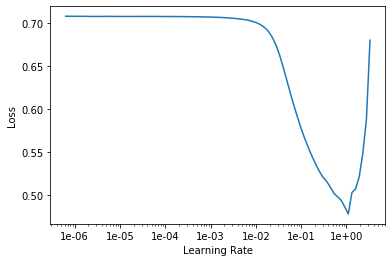

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, slice(1e-1,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.036790,0.036040,0.990762,0.631532,0.479865,0.153044,0.048466,0.885159,0.480983,0.152613,0.118838,0.964687,0.490564,0.149087,0.234322,0.979273,0.499448,0.144858,0.284783,0.986765,0.516147,0.134859,0.292799,0.989082,0.532471,0.124707,0.260984,0.990155,0.544655,0.114289,0.226629,0.990762,0.551940,0.105627,0.192020,05:43
1,0.032538,0.029851,0.991685,0.564355,0.619450,0.214370,0.043037,0.872300,0.620397,0.212794,0.123999,0.964811,0.625698,0.206860,0.278841,0.980502,0.631779,0.199857,0.360272,0.988259,0.647043,0.184702,0.396147,0.990496,0.660422,0.171529,0.372433,0.991379,0.677631,0.159730,0.330218,0.991685,0.686470,0.146899,0.279123,06:52
2,0.027529,0.025054,0.992436,0.670636,0.716869,0.274444,0.056360,0.910533,0.717268,0.272832,0.167536,0.974549,0.722630,0.265255,0.356487,0.985394,0.727280,0.257105,0.444511,0.990634,0.743884,0.240902,0.480925,0.991986,0.760817,0.226177,0.454451,0.992372,0.781418,0.211695,0.409997,0.992436,0.795008,0.196831,0.355742,06:10


In [18]:
learn.save('first_tt')

In [19]:
learn.load('first_tt')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council decision < date > xxunk amount development fund acp state hand country department eec council community treaty community agreement administration community aid sign hereinafter call agreement < reference > proposal commission surinam state country territory community virtue decision request accede convention lomã © pursuant < reference > thereof whereas council minister request state deposit instrument accession secretariat council convention lomã © july < date><date > < reference > agreement amount country territory < reference > b agreement provide state subparagraph paragraph < reference > text < reference > b agreement text > pic file= t < reference > decision force < date > < reference > decision community < date > council president j silkin < date > p < date > p,xxbos commission recommendation member state concern protection bird habitat eec title chapter paragraph programme action commun

In [20]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


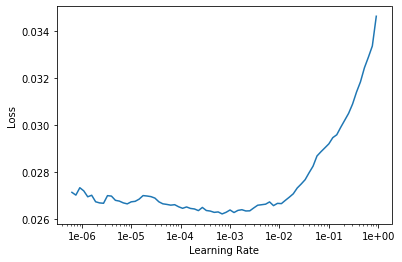

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.027211,0.026960,0.991769,0.504291,0.845364,0.117521,0.037282,0.876210,0.845034,0.115936,0.127517,0.974800,0.842413,0.109615,0.350661,0.987337,0.831991,0.102576,0.445883,0.991743,0.840779,0.090490,0.427727,0.992244,0.842354,0.079340,0.340481,0.992090,0.838789,0.069836,0.251219,0.991769,0.843550,0.061476,0.172569,06:08
1,0.025923,0.024308,0.992675,0.692190,0.747420,0.291445,0.061657,0.916358,0.748692,0.290395,0.180563,0.976144,0.754661,0.284836,0.375925,0.986193,0.761325,0.277441,0.462030,0.991058,0.774433,0.261536,0.498107,0.992303,0.788818,0.246061,0.476480,0.992668,0.800795,0.230669,0.434807,0.992675,0.811897,0.215104,0.380967,07:24
2,0.024837,0.023584,0.992841,0.693723,0.751770,0.316534,0.062036,0.915056,0.753355,0.315212,0.180321,0.975661,0.758975,0.309087,0.379824,0.985967,0.767262,0.301159,0.469918,0.991055,0.781883,0.286284,0.514313,0.992391,0.796757,0.272285,0.496979,0.992804,0.809884,0.257007,0.461300,0.992841,0.824834,0.242667,0.409963,06:19
3,0.024403,0.023453,0.992888,0.698736,0.759156,0.317917,0.062173,0.917130,0.760767,0.316797,0.181449,0.976209,0.763554,0.309708,0.383137,0.986280,0.770115,0.302051,0.474869,0.991165,0.781134,0.286816,0.516303,0.992473,0.794626,0.273199,0.498966,0.992850,0.803897,0.258438,0.464052,0.992888,0.817166,0.245205,0.412265,06:57


In [23]:
learn.save('second_tt')

In [24]:
learn.load('second_tt')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council decision < date > xxunk amount development fund acp state hand country department eec council community treaty community agreement administration community aid sign hereinafter call agreement < reference > proposal commission surinam state country territory community virtue decision request accede convention lomã © pursuant < reference > thereof whereas council minister request state deposit instrument accession secretariat council convention lomã © july < date><date > < reference > agreement amount country territory < reference > b agreement provide state subparagraph paragraph < reference > text < reference > b agreement text > pic file= t < reference > decision force < date > < reference > decision community < date > council president j silkin < date > p < date > p,xxbos commission recommendation member state concern protection bird habitat eec title chapter paragraph programme action commun

In [25]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


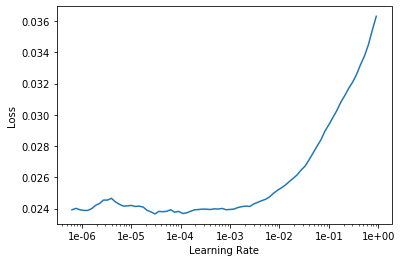

In [27]:
learn.lr_find()
learn.recorder.plot()

#stop

In [29]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.024462,0.023131,0.992966,0.720459,0.748469,0.339401,0.067150,0.921715,0.749509,0.338192,0.190780,0.976731,0.754838,0.332632,0.389804,0.986293,0.762008,0.326227,0.475993,0.991209,0.773707,0.310739,0.521726,0.992504,0.787108,0.294174,0.507473,0.992930,0.802167,0.280975,0.477147,0.992966,0.812133,0.266999,0.429211,08:43
1,0.024246,0.022713,0.993095,0.729066,0.753711,0.357357,0.069654,0.923283,0.755958,0.355800,0.196047,0.977279,0.760693,0.350251,0.397288,0.986641,0.767164,0.342628,0.487620,0.991363,0.780065,0.326368,0.535865,0.992644,0.793856,0.311404,0.525169,0.993017,0.808524,0.295507,0.491892,0.993095,0.818701,0.281988,0.449721,06:41
2,0.023117,0.022297,0.993190,0.715481,0.774594,0.354057,0.066596,0.922982,0.776714,0.352966,0.195348,0.977876,0.782167,0.346954,0.404139,0.987125,0.789988,0.339864,0.496048,0.991687,0.801433,0.324502,0.543680,0.992884,0.813204,0.309813,0.531127,0.993198,0.825474,0.295482,0.495711,0.993190,0.833911,0.279584,0.450174,08:27
3,0.022728,0.022177,0.993228,0.722725,0.771512,0.362565,0.067324,0.923241,0.772782,0.360842,0.195235,0.977598,0.777123,0.353968,0.402338,0.986875,0.784755,0.346957,0.494977,0.991650,0.796877,0.333098,0.548113,0.992836,0.810970,0.317741,0.536641,0.993193,0.825096,0.302861,0.501157,0.993228,0.835383,0.287334,0.458007,08:43


In [30]:
learn.save('third_tt')

In [31]:
learn.load('third_tt')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council decision < date > xxunk amount development fund acp state hand country department eec council community treaty community agreement administration community aid sign hereinafter call agreement < reference > proposal commission surinam state country territory community virtue decision request accede convention lomã © pursuant < reference > thereof whereas council minister request state deposit instrument accession secretariat council convention lomã © july < date><date > < reference > agreement amount country territory < reference > b agreement provide state subparagraph paragraph < reference > text < reference > b agreement text > pic file= t < reference > decision force < date > < reference > decision community < date > council president j silkin < date > p < date > p,xxbos commission recommendation member state concern protection bird habitat eec title chapter paragraph programme action commun

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


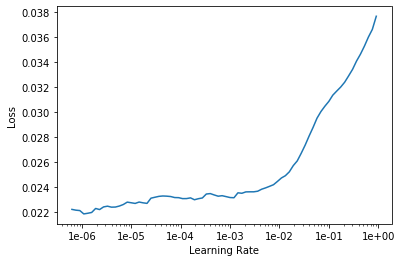

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) 


epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.022618,0.022131,0.993225,0.726872,0.769059,0.363700,0.068543,0.924564,0.770563,0.362022,0.198244,0.977950,0.776452,0.356750,0.406249,0.987030,0.782667,0.348883,0.497564,0.991683,0.796245,0.334645,0.548894,0.992878,0.807782,0.319521,0.537157,0.993222,0.821055,0.304906,0.503825,0.993225,0.835713,0.290290,0.459284,07:21
1,0.022832,0.022041,0.993286,0.728713,0.772738,0.370690,0.069757,0.925034,0.773732,0.369413,0.201139,0.978019,0.778890,0.363755,0.410118,0.986990,0.784913,0.355969,0.499322,0.991660,0.796693,0.341010,0.549647,0.992855,0.809047,0.326665,0.539547,0.993268,0.820384,0.312446,0.508530,0.993286,0.831288,0.297192,0.466422,08:55
2,0.022981,0.021995,0.993279,0.740544,0.766126,0.372551,0.072188,0.928093,0.767591,0.371299,0.204895,0.978388,0.772634,0.365129,0.411901,0.987205,0.779450,0.357448,0.501682,0.991695,0.791803,0.342753,0.551666,0.992951,0.804493,0.327776,0.545664,0.993257,0.822903,0.312562,0.513462,0.993279,0.834337,0.297061,0.468141,09:33
3,0.022876,0.021906,0.993327,0.745276,0.763447,0.384406,0.076442,0.928823,0.764670,0.382984,0.212771,0.978642,0.768849,0.377757,0.418223,0.987339,0.774597,0.370710,0.506796,0.991721,0.787329,0.355965,0.554299,0.992933,0.798464,0.342360,0.545688,0.993317,0.807995,0.328583,0.518901,0.993327,0.815834,0.313456,0.476769,08:37
4,0.021939,0.021707,0.993375,0.734523,0.780066,0.376869,0.071788,0.927559,0.780952,0.375828,0.207170,0.979150,0.786735,0.370655,0.420542,0.987742,0.793524,0.362465,0.511803,0.991953,0.803383,0.346800,0.557176,0.993076,0.817808,0.332116,0.546967,0.993411,0.827359,0.316051,0.515370,0.993375,0.836248,0.301356,0.469874,08:20
5,0.021533,0.021394,0.993482,0.749775,0.764668,0.407345,0.076318,0.929223,0.765605,0.406008,0.214428,0.978488,0.770652,0.399430,0.422842,0.987191,0.779034,0.392072,0.514405,0.991733,0.790423,0.377146,0.565894,0.992956,0.803394,0.362377,0.562597,0.993437,0.813452,0.347616,0.540029,0.993482,0.822130,0.333188,0.500787,09:49
6,0.021061,0.021248,0.993498,0.769818,0.760997,0.415189,0.083269,0.935315,0.762382,0.413604,0.228087,0.979863,0.768595,0.407791,0.435380,0.987766,0.774934,0.399772,0.522987,0.991864,0.787819,0.385466,0.571917,0.993038,0.798735,0.370392,0.568977,0.993459,0.809230,0.356600,0.544672,0.993498,0.821279,0.342777,0.505611,09:22
7,0.020424,0.020986,0.993586,0.731064,0.800271,0.391905,0.070162,0.927743,0.801407,0.390238,0.207601,0.979439,0.805499,0.384032,0.430806,0.988066,0.811354,0.376864,0.527833,0.992269,0.822355,0.362945,0.577456,0.993356,0.834113,0.346296,0.568827,0.993645,0.845050,0.331667,0.536976,0.993586,0.857485,0.315704,0.491135,08:25
8,0.020506,0.020761,0.993672,0.773053,0.778242,0.423904,0.083376,0.937565,0.778997,0.422244,0.233107,0.980928,0.783724,0.417529,0.447861,0.988363,0.789495,0.411095,0.535274,0.992254,0.801760,0.395231,0.582464,0.993345,0.813607,0.381253,0.578184,0.993648,0.825836,0.367046,0.552152,0.993672,0.836068,0.353731,0.515525,07:56
9,0.020227,0.020594,0.993722,0.755441,0.791389,0.418842,0.077923,0.933497,0.792286,0.417532,0.224716,0.980427,0.797464,0.412473,0.446474,0.988330,0.803400,0.404560,0.538007,0.992338,0.816048,0.388470,0.586425,0.993416,0.830595,0.373393,0.581722,0.993724,0.840210,0.357067,0.555910,0.993722,0.850956,0.344152,0.514515,09:41


In [35]:
learn.save('final_tt')

In [38]:
learn.load('final_tt')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (15613 items)
x: TextList
xxbos council < legalact > euratom guarantee fund action council union regard treaty community < reference > thereof regard treaty energy community < reference > thereof regard proposal commission regard opinion parliament opinion court auditor budget community increase risk result guarantee cover loan country council < date > conclude consideration prudent management discipline call mechanism fund set order cover risk loan guarantee cover loan country project country meet guarantee fund communitys creditor institution agree agreement < date > enter budget reserve relate lending guarantee operation country mechanism guarantee draw cash resource < reference > council < legalact > euratom decision eec euratom system community resource guarantee fund constitute payment resource whereas fund interest resource amount recover default debtor fund guarantee whereas reference practice institution ratio % guarantee fu

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


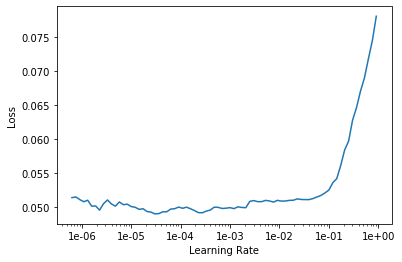

In [45]:
learn.load('final_tt')

learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7), wd=0.1) 

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.052654,0.061341,0.979425,0.572378,0.809147,0.609953,0.168885,0.842083,0.809706,0.608890,0.350959,0.942116,0.813228,0.603848,0.553287,0.962652,0.818091,0.597088,0.633335,0.974090,0.826936,0.585478,0.682357,0.977630,0.835819,0.571928,0.691378,0.979039,0.843477,0.559435,0.683665,0.979425,0.849802,0.549114,0.665389,07:35
1,0.052818,0.061058,0.979344,0.538509,0.804951,0.611585,0.155518,0.828683,0.805775,0.610893,0.329123,0.938891,0.809726,0.605674,0.541141,0.961362,0.815662,0.599558,0.626086,0.973626,0.824790,0.588135,0.681132,0.977465,0.834519,0.573904,0.691222,0.978863,0.842560,0.562003,0.683733,0.979344,0.849692,0.549958,0.665588,06:04
2,0.051061,0.060814,0.979419,0.550285,0.814042,0.603366,0.158307,0.839678,0.814780,0.602156,0.340996,0.943000,0.818438,0.597134,0.555047,0.963451,0.822140,0.590187,0.636183,0.974501,0.831913,0.578541,0.684943,0.978031,0.840532,0.567052,0.693148,0.979222,0.848282,0.555405,0.683122,0.979419,0.855578,0.542893,0.661143,07:21
3,0.052029,0.060846,0.979499,0.564320,0.815726,0.604055,0.163244,0.845613,0.816324,0.602311,0.349912,0.944798,0.819724,0.597272,0.562418,0.964391,0.824975,0.590620,0.640500,0.974863,0.834010,0.579214,0.687353,0.978175,0.842599,0.567345,0.694360,0.979356,0.849497,0.555058,0.684127,0.979499,0.855722,0.543269,0.663027,06:46


In [47]:
learn.save('post_final_tt')

In [82]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14016 items)
x: TextList
xxbos commission community com proposal < legalact > parliament council recognition navigability licence inland memorandum context people commission attach importance simplify community law clearer citizen opportunity chance use aim provision time instrument research work instrument rule reason codification rule community law transparent < date > commission instruct staff act amendment stress requirement department endeavour interval text community rule conclusion presidency council stress importance codification certainty law matter time codification compliance community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise 

## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [36]:
#learn.load('final_prep')
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [47]:
thresh = 0.25


print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.6109389348025713
P (micro) 0.6361300346599738
R (micro) 0.5876669979021751

F1 (macro) 0.3221019173626351
P (macro) 0.3927406128155411
R (macro)  0.302480847159898


In [38]:
f1_score(y_true, y_pred>thresh, average='macro')

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.24783135714937343

In [39]:
y_true_n = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true_n.shape

((3903, 511), (3903, 511))

In [40]:
metrics = classification_report(y_true_n, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

        1000       1.00      0.64      0.78        33
        1004       1.00      0.62      0.77         8
        1005       0.88      0.71      0.78       185
        1012       0.50      1.00      0.67         1
        1016       0.00      0.00      0.00         9
        1018       0.86      0.23      0.36        26
        1021       0.80      0.17      0.28        24
        1039       0.00      0.00      0.00         2
        1063       0.00      0.00      0.00         5
        1074       0.47      0.33      0.39        24
         108       0.00      0.00      0.00         0
        1086       0.00      0.00      0.00         9
        1087       0.00      0.00      0.00         0
        1088       0.00      0.00      0.00         5
        1089       0.00      0.00      0.00         0
          11       0.81      0.43      0.56       219
        1115       0.76      0.71      0.74        77
        1154       0.73    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [41]:
## precision at k
def tmp_precision(actual, predicted):
    #print(predicted)
    actual_one = np.where(actual == 1)[0]
    #print(actual_one)
    #print(type(actual_one))
    
    act_set = set(list(actual_one))
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def tmp_recall(actual, predicted):
    actual_one = np.where(actual == 1)[0]
    
    act_set = set(actual_one)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

## sort indizes in descending order
scores_idx_sorted = (-scores).argsort() 
    
#print(precs)
for i in range(7):
    k = i+1
    
    precs, recas = [], []
    for i in range(len(y_true_n)):
        precs.append( tmp_precision(y_true_n[i], scores_idx_sorted[i]) )
        recas.append( tmp_recall(y_true_n[i], scores_idx_sorted[i]) )
    
    print("Precision at: %d:   " % (k,), sum(precs)/len(precs))
    print("Recall at: %d:   " % (k,), sum(recas)/len(recas))
    print()

Precision at: 1:    0.8621573148859851
Recall at: 1:    0.20168378821338365

Precision at: 2:    0.7838841916474507
Recall at: 2:    0.361836438392938

Precision at: 3:    0.7033905542744852
Recall at: 3:    0.4790033307712016

Precision at: 4:    0.6347040737893928
Recall at: 4:    0.5690745620991564

Precision at: 5:    0.5694593902126504
Recall at: 5:    0.6330217089825068

Precision at: 6:    0.5106755487232043
Recall at: 6:    0.6771957061926294

Precision at: 7:    0.4634530214852987
Recall at: 7:    0.7140706782328592

